Scraping the data from Google Play RCTI+ Superapp reviews

In [1]:
import ssl
import pandas as pd
import numpy as np
from google_play_scraper import Sort, reviews

ssl._create_default_https_context = ssl._create_unverified_context

rplus_reviews, continuation_token = reviews(
    'com.fta.rctitv',
    sort=Sort.MOST_RELEVANT,
    count=1000
)

df = pd.DataFrame(rplus_reviews)
df.drop(['reviewId', 'userName', 'userImage', 'thumbsUpCount',
    'reviewCreatedVersion', 'replyContent', 'repliedAt', 'at'], axis=1, inplace=True)
df.head()

,content,score
0,14-second ad for broadcasts that run ads longe...,2
1,It's a great application for an alternative to...,5
2,"Good apps. It's very easy to use, imteresting ...",5
3,"This is a great app, actually. It's very inter...",5
4,Its actually pretty good even the ui/ux is not...,5


Preprocessing the reviews

In [2]:
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
import string

nltk.download('stopwords')

#stemmer = nltk.SnowballStemmer('english', 'indonesian')
#stopword = set(stopwords.words('english', 'indonesian'))

stemmer = nltk.SnowballStemmer('english')
stopword = set(stopwords.words('indonesian'))

def remove_emojis(data):
    emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
    return re.sub(emoj, '', data)

def clean(text):
    text = str(text).lower()                                          # transform text to lowercase
    text = re.sub('\[.*?\]', '', text)                                # remove '[]' and any words in it
    text = re.sub('https?://\S+|www\.\S+', '', text)                  # remove links
    text = re.sub('<.*?>+', '', text)                                 # remove '<>' and any words in it
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)   # remove punctuation
    text = re.sub('\n', '', text)                                     # remove line feeds
    text = remove_emojis(text)                                        # remove emojis
    text = re.sub('\w*\d\w*', '', text)                               # remove numbers and words with numbers
    text = [word for word in text.split(' ') if word not in stopword] # remove stopwords
    text = [stemmer.stem(word) for word in text]                      # stem the text
    text = " ".join(text)                                             # put words back together to form a text
    return text

df['content_clean'] = df['content'].apply(clean)

df['content_clean']

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/riobatubara/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


0       ad for broadcast that run ad longer than  min...
1      it a great applic for an altern to watch show ...
2      good app it veri easi to use imterest and make...
3      this is a great app actual it veri interest al...
4      it actual pretti good even the uiux is not eas...
                             ...                        
995                                       good i like it
996                             rcti indonesia suckkssss
997                                thank you for rate us
998                     pen liat masterchef season  wkwk
999                   masterchef indonesia sangatt seruu
Name: content_clean, Length: 1000, dtype: object

Creating sentiment score

In [3]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

nltk.download('vader_lexicon')

sentiments = SentimentIntensityAnalyzer()

df['positive'] = [sentiments.polarity_scores(i)['pos'] for i in df['content_clean']]
df['negative'] = [sentiments.polarity_scores(i)['neg'] for i in df['content_clean']]
df['neutral'] = [sentiments.polarity_scores(i)['neu'] for i in df['content_clean']]
df['compound'] = [sentiments.polarity_scores(i)['compound'] for i in df['content_clean']]

df = df[['content', 'content_clean', 'score', 'positive', 'negative', 'neutral', 'compound']]
df

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/riobatubara/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


,content,content_clean,score,positive,negative,neutral,compound
0,14-second ad for broadcasts that run ads longe...,ad for broadcast that run ad longer than min...,2,0.000,0.054,0.946,-0.4939
1,It's a great application for an alternative to...,it a great applic for an altern to watch show ...,5,0.156,0.000,0.844,0.6751
2,"Good apps. It's very easy to use, imteresting ...",good app it veri easi to use imterest and make...,5,0.263,0.000,0.737,0.6908
3,"This is a great app, actually. It's very inter...",this is a great app actual it veri interest al...,5,0.341,0.000,0.659,0.8845
4,Its actually pretty good even the ui/ux is not...,it actual pretti good even the uiux is not eas...,5,0.089,0.000,0.911,0.2382
...,...,...,...,...,...,...,...
995,Good I like it,good i like it,5,0.844,0.000,0.156,0.6597
996,RCTI Indonesia suckkssss!!!,rcti indonesia suckkssss,1,0.000,0.000,1.000,0.0000
997,Thank you for rating us,thank you for rate us,5,0.385,0.000,0.615,0.3612
998,Cuma pen liat masterchef season 7 wkwk,pen liat masterchef season wkwk,5,0.000,0.000,1.000,0.0000


In [4]:
result = df["compound"].values
sentiment = []

for i in result:
    if i >= 0.05 :
        sentiment.append('Positive')
    elif i <= -0.05 :
        sentiment.append('Negative')
    else:
        sentiment.append('Neutral')
        
df["sentiment"] = sentiment
df.head()

,content,content_clean,score,positive,negative,neutral,compound,sentiment
0,14-second ad for broadcasts that run ads longe...,ad for broadcast that run ad longer than min...,2,0.000,0.054,0.946,-0.4939,Negative
1,It's a great application for an alternative to...,it a great applic for an altern to watch show ...,5,0.156,0.000,0.844,0.6751,Positive
2,"Good apps. It's very easy to use, imteresting ...",good app it veri easi to use imterest and make...,5,0.263,0.000,0.737,0.6908,Positive
3,"This is a great app, actually. It's very inter...",this is a great app actual it veri interest al...,5,0.341,0.000,0.659,0.8845,Positive
4,Its actually pretty good even the ui/ux is not...,it actual pretti good even the uiux is not eas...,5,0.089,0.000,0.911,0.2382,Positive


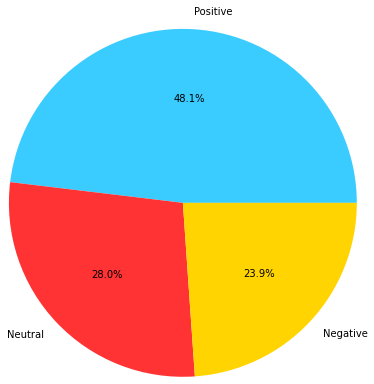

In [5]:
import matplotlib.pyplot as plt

scores = df['sentiment'].value_counts()

plt.pie(df['sentiment'].value_counts(), 
        labels=scores.index, 
        autopct='%1.1f%%', 
        radius=2, 
        colors=['#3bccff','#ff3333', '#ffd400'])
plt.show()

In [6]:
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
import random

# separate dataframe into sentiments for separated analysis
df_positive = df.loc[df['sentiment'] == 'Positive']
df_negative = df.loc[df['sentiment'] == 'Negative']
text_positive = ' '.join(i for i in df_positive['content_clean'])
text_negative = ' '.join(i for i in df_negative['content_clean'])

def color_func_positive(word=None, font_size=None, position=None, orientation=None, font_path=None, random_state=None):
    color = '#3bccff' + str(random.randrange(50, 100, 10))
    return color

def color_func_negative(word=None, font_size=None, position=None, orientation=None, font_path=None, random_state=None):
    color = '#ff3333' + str(random.randrange(50, 100, 10))
    return color

wc_stopwords = set(STOPWORDS)

wordcloud_positive = WordCloud(stopwords=wc_stopwords,
                               background_color="white",
                               colormap="inferno", 
                               color_func=color_func_positive).generate(text_positive)

wordcloud_negative = WordCloud(stopwords=wc_stopwords,
                               background_color="white",
                               colormap="inferno", 
                               color_func=color_func_negative).generate(text_negative)

figure, axis = plt.subplots(1,2, figsize=(15, 15))
axis[0].imshow(wordcloud_positive, interpolation='bilinear')
axis[0].set_title('Positive sentiment')
axis[0].axis('off')
axis[1].imshow(wordcloud_negative, interpolation='bilinear')
axis[1].set_title('Negative sentiment')
axis[1].axis('off')

plt.show()

ModuleNotFoundError: No module named 'wordcloud'